In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../src')))

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

from train_utils import BatteryTrainerBase

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load the synthesized pack-level dataframe
pack_df = pd.read_pickle("../../../Datasets/pack_df_isu.pkl")

# Required for split logic compatibility
pack_df['cell_id'] = pack_df['pack_uid'].str.split(',').str[0]
pack_df['source'] = 'isu'

pack_df.head()


,group,cycle_index,pack_uid,soh,soh_mean,soh_std,soh_min,soh_max,cell_id_percel,capacity_percel,...,i_interp_498_mean,i_interp_498_std,i_interp_498_min,i_interp_498_max,i_interp_499_mean,i_interp_499_std,i_interp_499_min,i_interp_499_max,cell_id,source
0,1,0,1_c0,1.123236,1.123236,0.005048,1.117594,1.129744,"[G1C1, G1C2, G1C3, G1C4]","[0.28045655555555554, 0.2824359444444444, 0.27...",...,0.05,1.439294e-07,0.05,0.05,0.05,1.473557e-07,0.05,0.05,1_c0,isu
1,1,1,1_c1,1.122228,1.122228,0.005837,1.115733,1.128989,"[G1C1, G1C2, G1C3, G1C4]","[0.2798555555555556, 0.2822472222222222, 0.278...",...,0.05,8.131642e-17,0.05,0.05,0.05,8.638853e-17,0.05,0.05,1_c1,isu
2,1,2,1_c2,1.115976,1.115976,0.006297,1.108056,1.122011,"[G1C1, G1C2, G1C3, G1C4]","[0.27847913888888887, 0.28050277777777777, 0.2...",...,0.05,1.702977e-16,0.05,0.05,0.05,1.725447e-16,0.05,0.05,1_c2,isu
3,1,3,1_c3,1.110242,1.110242,0.007059,1.100872,1.116244,"[G1C1, G1C2, G1C3, G1C4]","[0.27719027777777777, 0.27906111111111115, 0.2...",...,0.05,2.165187e-16,0.05,0.05,0.05,2.174433e-16,0.05,0.05,1_c3,isu
4,1,4,1_c4,1.107967,1.107967,0.007142,1.098094,1.113944,"[G1C1, G1C2, G1C3, G1C4]","[0.27685969444444447, 0.2784861111111111, 0.27...",...,0.05,2.565202e-17,0.05,0.05,0.05,2.687422e-17,0.05,0.05,1_c4,isu


In [2]:
class BatteryFFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2, dropout=0.0):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout)]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Dropout(dropout)]
        layers += [nn.Linear(hidden_dim, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class PackTrainer(BatteryTrainerBase):
    def train(self, train_df, val_df, feature_cols=None, epochs=20, **model_kwargs):
        X_train = torch.tensor(train_df[feature_cols].values, dtype=torch.float32)
        y_train = torch.tensor(train_df[self.target_cols[0]].values, dtype=torch.float32).unsqueeze(1)
        X_val = torch.tensor(val_df[feature_cols].values, dtype=torch.float32)
        y_val = torch.tensor(val_df[self.target_cols[0]].values, dtype=torch.float32).unsqueeze(1)

        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=model_kwargs.get("batch_size", 32), shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=model_kwargs.get("batch_size", 32))

        model = BatteryFFNN(
            input_dim=len(feature_cols),
            hidden_dim=model_kwargs.get("hidden_dim", 128),
            num_layers=model_kwargs.get("num_layers", 2),
            dropout=model_kwargs.get("dropout", 0.0)
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=model_kwargs.get("lr", 1e-3))
        criterion = nn.MSELoss()

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                pred = model(xb)
                loss = criterion(pred, yb)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb)
                val_preds.append(pred.numpy())
                val_targets.append(yb.numpy())

        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)

        print(f"FFNN Val MSE={mean_squared_error(val_targets, val_preds):.4f}, MAE={mean_absolute_error(val_targets, val_preds):.4f}, R²={r2_score(val_targets, val_preds):.4f}")
        return model, val_targets, val_preds

    def optuna_objective(self, trial):
        hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 256])
        num_layers = trial.suggest_int("num_layers", 1, 2)
        dropout = trial.suggest_float("dropout", 0.0, 0.1, step=0.1)
        lr = trial.suggest_categorical("lr", [1e-2, 1e-3, 1e-4])
        batch_size = trial.suggest_categorical("batch_size", [18, 32, 64])

        result = self.cross_validate(
            lr=lr,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_size=batch_size
        )

        std_mse = np.std(result.mse)
        score = result.avg_mse + 0.8 * std_mse
        return score

In [3]:
trainer = PackTrainer(pack_df, target_cols=['soh'])
trainer.cross_validate()


=== Fold 1 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0112, MAE=0.0846, R²=0.6641
  MSE: 0.0112, MAE: 0.0846, R²: 0.6641

=== Fold 2 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0066, MAE=0.0621, R²=0.7924
  MSE: 0.0066, MAE: 0.0621, R²: 0.7924

=== Fold 3 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0154, MAE=0.0954, R²=0.5437
  MSE: 0.0154, MAE: 0.0954, R²: 0.5437

=== Fold 4 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0160, MAE=0.0926, R²=0.4706
  MSE: 0.0160, MAE: 0.0926, R²: 0.4706

=== Fold 5 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0080, MAE=0.0643, R²=0.7628
  MSE: 0.0080, MAE: 0.0643, R²: 0.7628

=== Average CV Performance ===
Avg MSE: 0.0114
Avg MAE: 0.0798
Avg R² : 0.6467


CVResult(mse=[0.011168317, 0.0066189696, 0.0153507395, 0.015981624, 0.00803383], mae=[0.084631786, 0.062105916, 0.095433675, 0.09259143, 0.0643442], r2=[0.6640815734863281, 0.7924388647079468, 0.5436592102050781, 0.4706471562385559, 0.7628384828567505], avg_mse=0.011430697, avg_mae=0.0798214, avg_r2=0.6467330574989318)

In [4]:
trainer.run_optuna_tuning()

[I 2025-04-21 13:14:04,835] A new study created in memory with name: no-name-c9710fff-05c8-4604-bcb6-c75981c0a8bb



=== Fold 1 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0150, MAE=0.0883, R²=0.5487
  MSE: 0.0150, MAE: 0.0883, R²: 0.5487

=== Fold 2 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0090, MAE=0.0754, R²=0.7166
  MSE: 0.0090, MAE: 0.0754, R²: 0.7166

=== Fold 3 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0102, MAE=0.0704, R²=0.6968
  MSE: 0.0102, MAE: 0.0704, R²: 0.6968

=== Fold 4 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0150, MAE=0.0937, R²=0.5047
  MSE: 0.0150, MAE: 0.0937, R²: 0.5047

=== Fold 5 ===
[isu] Normalizing 4030 features


[I 2025-04-21 13:14:31,130] Trial 0 finished with value: 0.01423395574092865 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.0, 'lr': 0.0001, 'batch_size': 32}. Best is trial 0 with value: 0.01423395574092865.


FFNN Val MSE=0.0123, MAE=0.0852, R²=0.6377
  MSE: 0.0123, MAE: 0.0852, R²: 0.6377

=== Average CV Performance ===
Avg MSE: 0.0123
Avg MAE: 0.0826
Avg R² : 0.6209

=== Fold 1 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0955, MAE=0.2198, R²=-1.8723
  MSE: 0.0955, MAE: 0.2198, R²: -1.8723

=== Fold 2 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0143, MAE=0.0944, R²=0.5516
  MSE: 0.0143, MAE: 0.0944, R²: 0.5516

=== Fold 3 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0324, MAE=0.1382, R²=0.0369
  MSE: 0.0324, MAE: 0.1382, R²: 0.0369

=== Fold 4 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0195, MAE=0.1010, R²=0.3527
  MSE: 0.0195, MAE: 0.1010, R²: 0.3527

=== Fold 5 ===
[isu] Normalizing 4030 features


[I 2025-04-21 13:14:48,902] Trial 1 finished with value: 0.061040798574686056 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.001, 'batch_size': 32}. Best is trial 0 with value: 0.01423395574092865.


FFNN Val MSE=0.0246, MAE=0.1165, R²=0.2743
  MSE: 0.0246, MAE: 0.1165, R²: 0.2743

=== Average CV Performance ===
Avg MSE: 0.0373
Avg MAE: 0.1340
Avg R² : -0.1313

=== Fold 1 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0089, MAE=0.0699, R²=0.7337
  MSE: 0.0089, MAE: 0.0699, R²: 0.7337

=== Fold 2 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0068, MAE=0.0612, R²=0.7867
  MSE: 0.0068, MAE: 0.0612, R²: 0.7867

=== Fold 3 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0097, MAE=0.0732, R²=0.7131
  MSE: 0.0097, MAE: 0.0732, R²: 0.7131

=== Fold 4 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0081, MAE=0.0650, R²=0.7312
  MSE: 0.0081, MAE: 0.0650, R²: 0.7312

=== Fold 5 ===
[isu] Normalizing 4030 features


[I 2025-04-21 13:15:49,592] Trial 2 finished with value: 0.009147504298016428 and parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.0, 'lr': 0.001, 'batch_size': 18}. Best is trial 2 with value: 0.009147504298016428.


FFNN Val MSE=0.0085, MAE=0.0699, R²=0.7476
  MSE: 0.0085, MAE: 0.0699, R²: 0.7476

=== Average CV Performance ===
Avg MSE: 0.0084
Avg MAE: 0.0679
Avg R² : 0.7425

=== Fold 1 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0230, MAE=0.1134, R²=0.3095
  MSE: 0.0230, MAE: 0.1134, R²: 0.3095

=== Fold 2 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0237, MAE=0.1204, R²=0.2579
  MSE: 0.0237, MAE: 0.1204, R²: 0.2579

=== Fold 3 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0225, MAE=0.1080, R²=0.3322
  MSE: 0.0225, MAE: 0.1080, R²: 0.3322

=== Fold 4 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0333, MAE=0.1396, R²=-0.1041
  MSE: 0.0333, MAE: 0.1396, R²: -0.1041

=== Fold 5 ===
[isu] Normalizing 4030 features


[I 2025-04-21 13:16:11,747] Trial 3 finished with value: 0.03242126666009426 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.01, 'batch_size': 64}. Best is trial 2 with value: 0.009147504298016428.


FFNN Val MSE=0.0363, MAE=0.1504, R²=-0.0707
  MSE: 0.0363, MAE: 0.1504, R²: -0.0707

=== Average CV Performance ===
Avg MSE: 0.0277
Avg MAE: 0.1263
Avg R² : 0.1450

=== Fold 1 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0058, MAE=0.0590, R²=0.8258
  MSE: 0.0058, MAE: 0.0590, R²: 0.8258

=== Fold 2 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0077, MAE=0.0721, R²=0.7588
  MSE: 0.0077, MAE: 0.0721, R²: 0.7588

=== Fold 3 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0058, MAE=0.0588, R²=0.8290
  MSE: 0.0058, MAE: 0.0588, R²: 0.8290

=== Fold 4 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0078, MAE=0.0669, R²=0.7403
  MSE: 0.0078, MAE: 0.0669, R²: 0.7403

=== Fold 5 ===
[isu] Normalizing 4030 features


[I 2025-04-21 13:16:47,368] Trial 4 finished with value: 0.007332430873066187 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 18}. Best is trial 4 with value: 0.007332430873066187.


FFNN Val MSE=0.0045, MAE=0.0515, R²=0.8661
  MSE: 0.0045, MAE: 0.0515, R²: 0.8661

=== Average CV Performance ===
Avg MSE: 0.0063
Avg MAE: 0.0617
Avg R² : 0.8040

=== Fold 1 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0285, MAE=0.1105, R²=0.1419
  MSE: 0.0285, MAE: 0.1105, R²: 0.1419

=== Fold 2 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0184, MAE=0.1054, R²=0.4226
  MSE: 0.0184, MAE: 0.1054, R²: 0.4226

=== Fold 3 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0222, MAE=0.1126, R²=0.3399
  MSE: 0.0222, MAE: 0.1126, R²: 0.3399

=== Fold 4 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0182, MAE=0.1023, R²=0.3962
  MSE: 0.0182, MAE: 0.1023, R²: 0.3962

=== Fold 5 ===
[isu] Normalizing 4030 features


[I 2025-04-21 13:17:04,651] Trial 5 finished with value: 0.025879814848303796 and parameters: {'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'batch_size': 64}. Best is trial 4 with value: 0.007332430873066187.


FFNN Val MSE=0.0258, MAE=0.1217, R²=0.2383
  MSE: 0.0258, MAE: 0.1217, R²: 0.2383

=== Average CV Performance ===
Avg MSE: 0.0226
Avg MAE: 0.1105
Avg R² : 0.3078

=== Fold 1 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0152, MAE=0.0890, R²=0.5422
  MSE: 0.0152, MAE: 0.0890, R²: 0.5422

=== Fold 2 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0152, MAE=0.0874, R²=0.5248
  MSE: 0.0152, MAE: 0.0874, R²: 0.5248

=== Fold 3 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0133, MAE=0.0831, R²=0.6051
  MSE: 0.0133, MAE: 0.0831, R²: 0.6051

=== Fold 4 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0194, MAE=0.0982, R²=0.3568
  MSE: 0.0194, MAE: 0.0982, R²: 0.3568

=== Fold 5 ===
[isu] Normalizing 4030 features


[I 2025-04-21 13:17:27,458] Trial 6 finished with value: 0.017090469785034656 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.0001, 'batch_size': 64}. Best is trial 4 with value: 0.007332430873066187.


FFNN Val MSE=0.0137, MAE=0.0817, R²=0.5968
  MSE: 0.0137, MAE: 0.0817, R²: 0.5968

=== Average CV Performance ===
Avg MSE: 0.0153
Avg MAE: 0.0879
Avg R² : 0.5251

=== Fold 1 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0087, MAE=0.0715, R²=0.7383
  MSE: 0.0087, MAE: 0.0715, R²: 0.7383

=== Fold 2 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0069, MAE=0.0628, R²=0.7825
  MSE: 0.0069, MAE: 0.0628, R²: 0.7825

=== Fold 3 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0109, MAE=0.0787, R²=0.6747
  MSE: 0.0109, MAE: 0.0787, R²: 0.6747

=== Fold 4 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0075, MAE=0.0711, R²=0.7526
  MSE: 0.0075, MAE: 0.0711, R²: 0.7526

=== Fold 5 ===
[isu] Normalizing 4030 features


[I 2025-04-21 13:17:55,322] Trial 7 finished with value: 0.009550237841904164 and parameters: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.01, 'batch_size': 32}. Best is trial 4 with value: 0.007332430873066187.


FFNN Val MSE=0.0082, MAE=0.0701, R²=0.7593
  MSE: 0.0082, MAE: 0.0701, R²: 0.7593

=== Average CV Performance ===
Avg MSE: 0.0084
Avg MAE: 0.0709
Avg R² : 0.7415

=== Fold 1 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0058, MAE=0.0607, R²=0.8246
  MSE: 0.0058, MAE: 0.0607, R²: 0.8246

=== Fold 2 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0027, MAE=0.0410, R²=0.9155
  MSE: 0.0027, MAE: 0.0410, R²: 0.9155

=== Fold 3 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0041, MAE=0.0525, R²=0.8780
  MSE: 0.0041, MAE: 0.0525, R²: 0.8780

=== Fold 4 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0073, MAE=0.0676, R²=0.7596
  MSE: 0.0073, MAE: 0.0676, R²: 0.7596

=== Fold 5 ===
[isu] Normalizing 4030 features


[I 2025-04-21 13:18:20,484] Trial 8 finished with value: 0.006011476647108794 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.1, 'lr': 0.001, 'batch_size': 18}. Best is trial 8 with value: 0.006011476647108794.


FFNN Val MSE=0.0036, MAE=0.0460, R²=0.8924
  MSE: 0.0036, MAE: 0.0460, R²: 0.8924

=== Average CV Performance ===
Avg MSE: 0.0047
Avg MAE: 0.0536
Avg R² : 0.8540

=== Fold 1 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0349, MAE=0.1468, R²=-0.0502
  MSE: 0.0349, MAE: 0.1468, R²: -0.0502

=== Fold 2 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0482, MAE=0.1796, R²=-0.5105
  MSE: 0.0482, MAE: 0.1796, R²: -0.5105

=== Fold 3 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0544, MAE=0.1870, R²=-0.6178
  MSE: 0.0544, MAE: 0.1870, R²: -0.6178

=== Fold 4 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0739, MAE=0.2274, R²=-1.4464
  MSE: 0.0739, MAE: 0.2274, R²: -1.4464

=== Fold 5 ===
[isu] Normalizing 4030 features


[I 2025-04-21 13:19:21,015] Trial 9 finished with value: 0.06099927350878716 and parameters: {'hidden_dim': 256, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.01, 'batch_size': 18}. Best is trial 8 with value: 0.006011476647108794.


FFNN Val MSE=0.0151, MAE=0.0961, R²=0.5551
  MSE: 0.0151, MAE: 0.0961, R²: 0.5551

=== Average CV Performance ===
Avg MSE: 0.0453
Avg MAE: 0.1674
Avg R² : -0.4140

Best trial:
  MSE: 0.0060
  Params:
    hidden_dim: 64
    num_layers: 2
    dropout: 0.1
    lr: 0.001
    batch_size: 18



Running cross-validation for base model...

=== Fold 1 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0105, MAE=0.0732, R²=0.6843
  MSE: 0.0105, MAE: 0.0732, R²: 0.6843

=== Fold 2 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0077, MAE=0.0647, R²=0.7588
  MSE: 0.0077, MAE: 0.0647, R²: 0.7588

=== Fold 3 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0060, MAE=0.0577, R²=0.8228
  MSE: 0.0060, MAE: 0.0577, R²: 0.8228

=== Fold 4 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0120, MAE=0.0827, R²=0.6019
  MSE: 0.0120, MAE: 0.0827, R²: 0.6019

=== Fold 5 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0119, MAE=0.0720, R²=0.6499
  MSE: 0.0119, MAE: 0.0720, R²: 0.6499

=== Average CV Performance ===
Avg MSE: 0.0096
Avg MAE: 0.0701
Avg R² : 0.7035

Running cross-validation for tuned model...

=== Fold 1 ===
[isu] Normalizing 4030 features
FFNN Val MSE=0.0032, MAE=0.0425, R²=0.9040
  MSE: 0.0032, MAE: 0.0425, R²: 0.9040

=== Fold 2 ===
[isu] Normalizing 4030 features
FFN

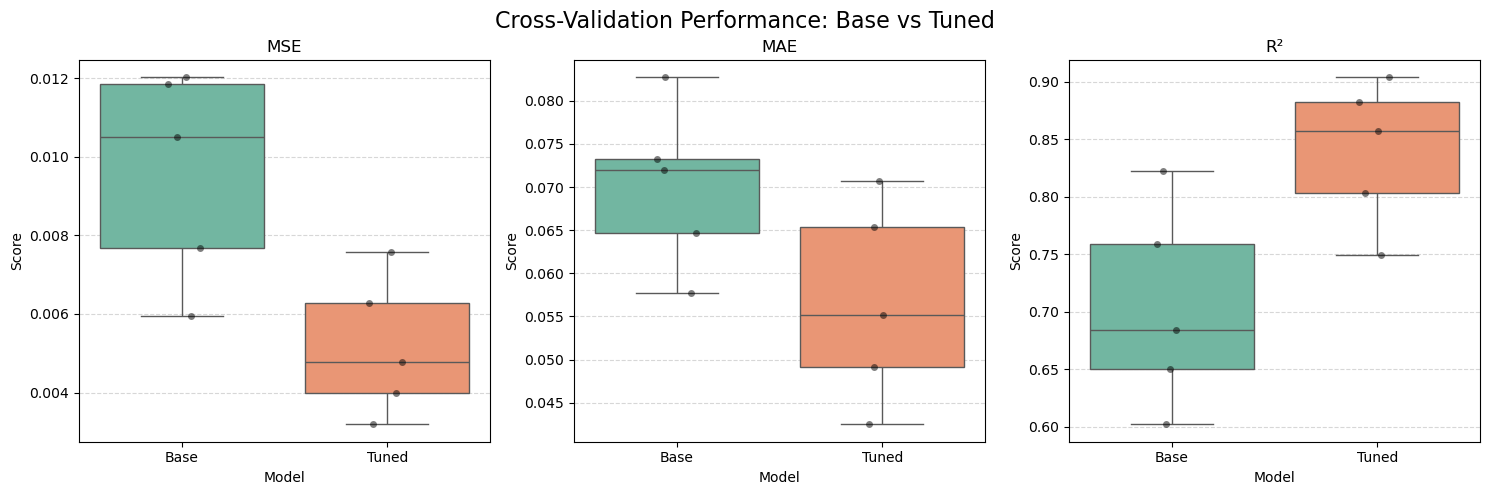

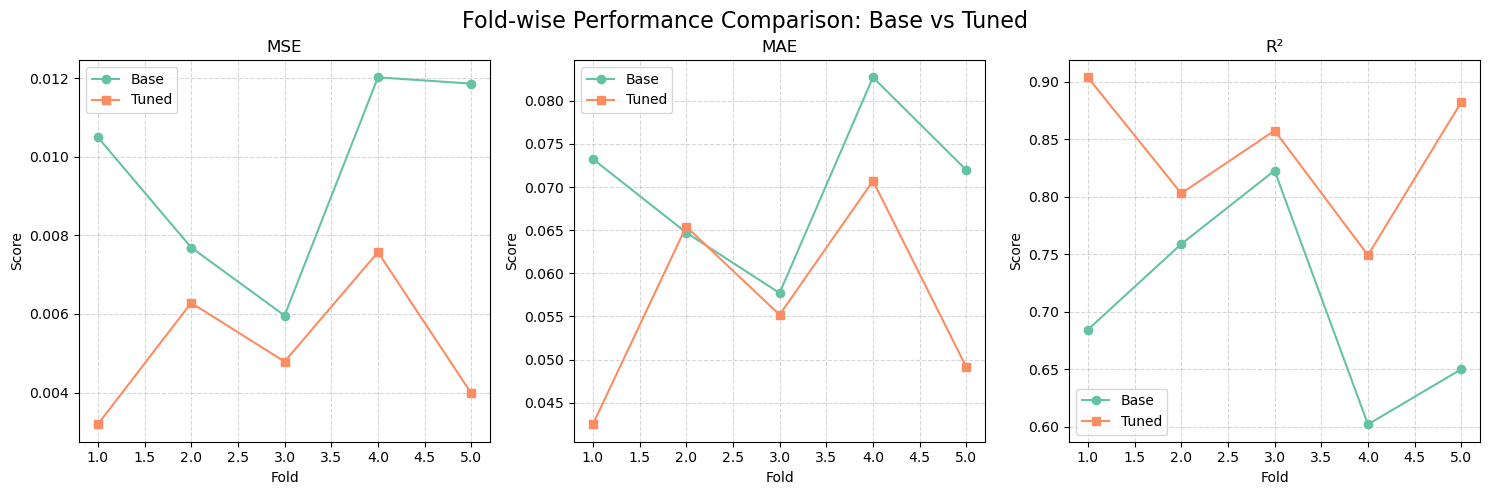

In [5]:
trainer.compare_base_vs_tuned_cv()